## Set up

In [1]:
from enum import Enum
from dataclasses import dataclass

import numpy as np
import tensorflow as tf
import keras as tfk
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import layers as tfkl

from pathlib import Path

sns.set_theme()

2024-11-12 12:20:38.193058: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 12:20:38.193782: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 12:20:38.202941: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 12:20:38.296279: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 12:20:40.382761: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
DATA_PATH = Path().absolute().parent / "data" / "training_set.npz"
PROFILING_DIR = Path().absolute().parent / "data" / "profiling"
EMBEDDINGS_DIR = Path().absolute().parent / "data" / "embeddings"
DATA_PATH

PosixPath('/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/homework-1/data/training_set.npz')

In [3]:
SEED = 42
BATCH_SIZE = 32
METRICS = ["accuracy", "recall", "f1_score"]

In [4]:
tfk.utils.set_random_seed(SEED)

In [5]:
@dataclass
class Hyperparameters:
    test_size = 1500
    layer_units = (256, 64)
    activation = "silu"
    optimiser = "adam"
    loss = "categorical_crossentropy"
    epochs = 500
    # Early stopping parameters
    patience = 10
    min_delta = 1e-5

hp = Hyperparameters()

In [6]:
class EmbeddingWidth(Enum):
    EfficientNetV2B3 = 1536

### Load

In [7]:
with np.load(DATA_PATH) as data:
    images = data["images"]
    labels = tfk.utils.to_categorical(data["labels"])

print(images.shape)
print(labels.shape)

(13759, 96, 96, 3)
(13759, 8)


#### Remove polluted images

<Axes: ylabel='Count'>

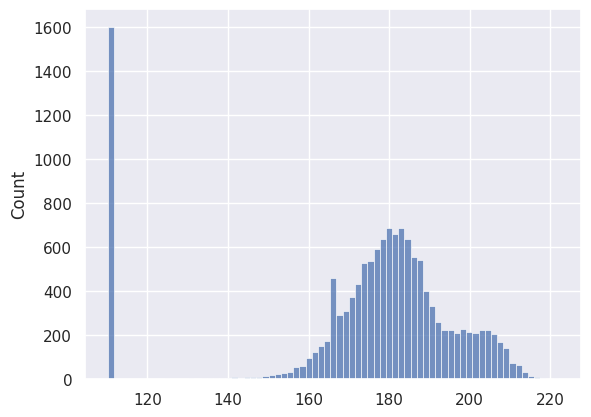

In [8]:
image_means: np.ndarray = images.mean(axis=(1, 2, 3))
sns.histplot(image_means)

In [9]:
TOLERANCE = 1e-4
MIN_DUPLICATES = 5

mean_indices = {}
for mean in image_means:
    indices = (np.abs(mean - image_means) <= TOLERANCE).nonzero()[0]
    if len(indices) > MIN_DUPLICATES:
        mean_indices[mean] = indices

len(mean_indices.keys())

2

In [10]:
for indices in mean_indices.values():
    print(np.unique(labels[indices]))

[0. 1.]
[0. 1.]


In [11]:
duplicated_indices = []
for indices in mean_indices.values():
    duplicated_indices.extend(indices)
duplicated_indices = np.array(duplicated_indices)
duplicated_indices.shape

(1800,)

In [12]:
original_indices = np.setdiff1d(
    list(range(images.shape[0])),
    duplicated_indices
)
original_indices.shape

(11959,)

In [13]:
clean_images = images[original_indices]
clean_labels = labels[original_indices]

print(clean_images.shape)
print(clean_labels.shape)

(11959, 96, 96, 3)
(11959, 8)


#### Separate data for validation

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    clean_images, clean_labels,
    test_size=hp.test_size,
    random_state=SEED,
    stratify=clean_labels,
)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(10459, 96, 96, 3)
(10459, 8)
(1500, 96, 96, 3)
(1500, 8)


In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)

## Model

In [16]:
def build(hp: Hyperparameters) -> tfk.Model:
    inputs = tfkl.Input((96, 96, 3))

    # ImageNet images are 224x224 so we need to resize to use the
    # pre-trained backbone feature extractor
    x = tfkl.Resizing(224, 224)(inputs)

    # TODO Move to hyperparameters
    # TODO Investigate changing `input_shape` to actual image shape
    # instead of resizing
    feature_extractor = tfk.applications.MobileNetV3Large(
        input_shape=(224, 224, 3),
        include_top=False,
        weights="imagenet",
        pooling="max",
    )
    feature_extractor.trainable = False
    x = feature_extractor(x)

    for units in Hyperparameters.layer_units:
        x = tfkl.Dense(
            units,
            activation=hp.activation,
        )(x)

    # Classification problem has 8 output classes
    # so the final layer has 8 neurons
    # with a softmax activation
    outputs = tfkl.Dense(8, activation="softmax")(x)

    return tfk.Model(inputs, outputs)

In [17]:
model = build(hp)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,259,336 (12.43 MB)

 Trainable params: 262,984 (1.00 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [18]:
def fit(hp: Hyperparameters, train: tf.data.Dataset, val: tf.data.Dataset) -> tuple[tfk.Model, tfk.callbacks.History]:
    model = build(hp)
    model.compile(
        optimizer=hp.optimiser,
        loss=hp.loss,
        metrics=METRICS,
    )
    history = model.fit(
        train.prefetch(tf.data.AUTOTUNE),
        batch_size=BATCH_SIZE,
        epochs=hp.epochs,
        validation_data=val.prefetch(tf.data.AUTOTUNE),
        callbacks=[
            tfk.callbacks.EarlyStopping(
                min_delta=hp.min_delta,
                patience=hp.patience,
                restore_best_weights=True,
            )
        ]
    )
    return model, history

In [19]:
model, history = fit(hp, train_dataset, val_dataset)

Epoch 1/500
 83/327 ━━━━━━━━━━━━━━━━━━━━ 1:51 457ms/step - accuracy: 0.4554 - f1_score: 0.4161 - loss: 4.3135 - recall: 0.4174

KeyboardInterrupt: 